<a href="https://colab.research.google.com/github/PLEX-GR00T/Data_Mining/blob/main/BigQuery_with_EDA_and_Model_Accelerations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9724578389814321750
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 102111199632162280
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

# 1. Loading the Data from the BigQuary

Here, we will authenticat our account, and will follow the steps to access our custom dataset. 


In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [ ]:
project_id = 'assignment-1-343200'

In [ ]:
!gcloud config list

[component_manager]
disable_update_check = True
[core]
account = priyank.thakkar@sjsu.edu
project = assignment-1-343200

Your active configuration is: [default]


In [ ]:
!gcloud config list project

[core]
project = assignment-1-343200

Your active configuration is: [default]


In [ ]:
!gcloud config set project 'assignment-1-343200'

Are you sure you wish to set property [core/project] to assignment-1-343200?

Do you want to continue (Y/n)?  y

Updated property [core/project].


In [ ]:
!gcloud config list project

[core]
project = assignment-1-343200

Your active configuration is: [default]


In [ ]:
from google.cloud import bigquery

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'assignment-1-343200'
client = bigquery.Client(project=project_id)

#Print your current data
for dataset in client.list_datasets():
  print(dataset.dataset_id)

Train


### 1.1 Libraries
* Import the libraries that we need to process our dataset further in the process.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

### 1.2  Fetch Dataset

* Fetch the dataset from the SQL query formate and convert that dataframe in to the Panda DataFrame, so that we can use the panda library on the our custom dataset. 

* Here we have to pass our Table Id available for our custom dataset from the Details options available BigQuary.

* Visualization of the First 10 rows of data.

In [ ]:
sql = """
SELECT
    *
FROM
    `assignment-1-343200.Train.Wids_Train`
"""
dfquery = client.query(sql)

df = pd.DataFrame(dfquery.to_dataframe())
df.head(10)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,2,State_1,Commercial,Education_Uncategorized,9100.0,NaN,NaN,958.6,34,56.758065,...,246,182,119,16,NaN,NaN,NaN,NaN,31.436683,377
1,2,State_1,Commercial,Education_Uncategorized,3200.0,NaN,NaN,958.6,34,56.758065,...,246,182,119,16,NaN,NaN,NaN,NaN,61.713289,378
2,2,State_1,Commercial,Education_Uncategorized,10120.0,NaN,NaN,186.8,40,58.032258,...,102,28,2,0,NaN,NaN,NaN,NaN,98.581878,386
3,2,State_1,Commercial,Education_Uncategorized,20854.0,NaN,NaN,92.0,22,46.629032,...,173,122,29,0,NaN,NaN,NaN,NaN,34.695615,387
4,2,State_1,Commercial,Education_Uncategorized,93124.0,NaN,NaN,92.0,29,51.774194,...,176,117,30,0,NaN,NaN,NaN,NaN,43.336266,388
5,2,State_1,Commercial,Education_Uncategorized,67693.0,NaN,NaN,92.0,29,51.774194,...,176,117,30,0,NaN,NaN,NaN,NaN,39.095601,389
6,2,State_1,Commercial,Education_Uncategorized,41995.0,NaN,NaN,123.1,28,49.306452,...,176,129,32,0,NaN,NaN,NaN,NaN,45.941062,391
7,2,State_1,Commercial,Education_Uncategorized,3800.0,NaN,NaN,123.1,28,49.306452,...,176,129,32,0,NaN,NaN,NaN,NaN,26.679343,392
8,2,State_1,Commercial,Education_Uncategorized,94602.0,NaN,NaN,123.1,29,51.774194,...,176,117,30,0,NaN,NaN,NaN,NaN,12.079947,393
9,2,State_1,Commercial,Education_Uncategorized,6050.0,NaN,NaN,506.6,15,38.274194,...,53,3,0,0,NaN,NaN,NaN,NaN,24.824587,398


### 1.3 Shape of data

In [ ]:
#How big is the dataset? Print in few rows of the dataset?
df.shape

(75757, 64)

# 2. Knowing the Data and Preprocessing 

### 2.1 Information of the data Columns.

The WiDS Dataset focuses on a prediction task involving roughly 100k observations of building energy usage records collected over 7 years and a number of states within the United States. The dataset consists of building characteristics (e.g. floor area, facility type etc), weather data for the location of the building (e.g. annual average temperature, annual total precipitation etc) as well as the energy usage for the building and the given year, measured as Site Energy Usage Intensity (Site EUI). Each row in the data corresponds to the a single building observed in a given year. Your task is to predict the Site EUI for each row, given the characteristics of the building and the weather data for the location of the building.

You are provided with two datasets: 

1.   the training dataset where the observed values of the Site EUI for each row is provided and 
2.   the test dataset where we withhold the observed values of the Site EUI for each row. 

### Data Dictionary

**id**: building id

**Year_Factor**: anonymized year in which the weather and energy usage factors were observed

**State_Factor**: anonymized state in which the building is located

**building_class**: building classification

**facility_type**: building usage type

**floor_area**: floor area (in square feet) of the building

**year_built**: year in which the building was constructed

**energy_star_rating**: the energy star rating of the building

**ELEVATION**: elevation of the building location

**january_min_temp**: minimum temperature in January (in Fahrenheit) at the location of the building

**january_avg_temp**: average temperature in January (in Fahrenheit) at the location of the building

**january_max_temp**: maximum temperature in January (in Fahrenheit) at the location of the building

**cooling_degree_days**: cooling degree day for a given day is the number of degrees where the daily average temperature exceeds 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.

**heating_degree_days**: heating degree day for a given day is the number of degrees where the daily average temperature falls under 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.

**precipitation_inches**: annual precipitation in inches at the location of the building

**snowfall_inches**: annual snowfall in inches at the location of the building

**snowdepth_inches**: annual snow depth in inches at the location of the building

**avg_temp**: average temperature over a year at the location of the building

**days_below_30F**: total number of days below 30 degrees Fahrenheit at the location of the building

**days_below_20F**: total number of days below 20 degrees Fahrenheit at the location of the building

**days_below_10F**: total number of days below 10 degrees Fahrenheit at the location of the building

**days_below_0F**: total number of days below 0 degrees Fahrenheit at the location of the building

**days_above_80F**: total number of days above 80 degrees Fahrenheit at the location of the building

**days_above_90F**: total number of days above 90 degrees Fahrenheit at the location of the building

**days_above_100F**: total number of days above 100 degrees Fahrenheit at the location of the building

**days_above_110F**: total number of days above 110 degrees Fahrenheit at the location of the building

**direction_max_wind_speed**: wind direction for maximum wind speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).

**direction_peak_wind_speed**: wind direction for peak wind gust speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).

**max_wind_speed**: maximum wind speed at the location of the building

**days_with_fog**: number of days with fog at the location of the building

#### Target
**site_eui**: Site Energy Usage Intensity is the amount of heat and electricity consumed by a building as reflected in utility bills


### 2.2 Checking for the Duplication

* For this we will check if is there any duplication of the data or not. Now this data has the 1st colums as the ID. 
* Panda does not detect the dubplicat until we drop the Id column, because it will be the same all the time. 
* After removing ID we will discard the duplicates. Which will do no good for our data representation ahead.

In [ ]:
df.drop(['id'], axis = 1, inplace=True)
df[df.duplicated()]
data = df.drop_duplicates()
print("Number of dubplicate rows dropped: " + str(df.shape[0]- data.shape[0]))

Number of dubplicate rows dropped: 39


### 2.3 Describe the data

In [ ]:
display(data.describe())

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui
count,75718.000000,7.571800e+04,73901.000000,49036.000000,75718.000000,75718.000000,75718.000000,75718.000000,75718.000000,75718.000000,...,75718.000000,75718.000000,75718.000000,75718.000000,75718.000000,34648.000000,33920.000000,34648.000000,29935.000000,75718.000000
mean,4.368393,1.657756e+05,1952.308440,61.049168,39.492266,11.431337,34.309172,59.053541,11.718469,35.524954,...,0.877136,82.708616,14.056407,0.279326,0.002443,66.575849,62.798231,4.191743,109.159312,82.568382
std,1.471110,2.456202e+05,37.057032,28.664237,60.553650,9.381661,6.995923,5.354621,12.577794,8.866980,...,2.894931,25.283873,10.940054,2.252150,0.142176,131.165788,130.323815,6.459697,50.707643,58.185549
min,1.000000,9.430000e+02,0.000000,0.000000,-6.400000,-19.000000,10.806452,42.000000,-13.000000,13.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,12.000000,1.001169
25%,3.000000,6.237000e+04,1927.000000,40.000000,11.900000,6.000000,29.827586,56.000000,2.000000,31.625000,...,0.000000,72.000000,6.000000,0.000000,0.000000,1.000000,1.000000,1.000000,88.000000,54.528562
50%,5.000000,9.136000e+04,1951.000000,67.000000,25.000000,11.000000,34.451613,59.000000,9.000000,34.107143,...,0.000000,84.000000,12.000000,0.000000,0.000000,1.000000,1.000000,1.000000,104.000000,75.293716
75%,6.000000,1.659360e+05,1977.000000,85.000000,42.700000,13.000000,37.322581,62.000000,20.000000,40.879310,...,0.000000,97.000000,17.000000,0.000000,0.000000,1.000000,1.000000,1.000000,131.000000,97.242302
max,6.000000,6.385382e+06,2015.000000,100.000000,1924.500000,49.000000,64.758065,91.000000,48.000000,65.107143,...,31.000000,260.000000,185.000000,119.000000,16.000000,360.000000,360.000000,23.300000,311.000000,997.866120


### 2.4 Datatype of the Data

In [ ]:
num_var = data.columns[data.dtypes != 'object']
cat_var = data.columns[data.dtypes == 'object']

print(num_var)
print(cat_var)

Index(['Year_Factor', 'floor_area', 'year_built', 'energy_star_rating',
       'ELEVATION', 'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inches',
       'snowdepth_inches', 'avg_temp', 'days_below_3

In [ ]:
# Second way of doing that is using Numpy 
from pprint import pprint

num = list(data.select_dtypes(include=[np.number]).columns)
obj = list(data.select_dtypes(exclude=[np.number]).columns)

print("(1) Numerics")
pprint(num)

print("(2) Non Numerics")
pprint(obj)

(1) Numerics
['Year_Factor',
 'floor_area',
 'year_built',
 'energy_star_rating',
 'ELEVATION',
 'january_min_temp',
 'january_avg_temp',
 'january_max_temp',
 'february_min_temp',
 'february_avg_temp',
 'february_max_temp',
 'march_min_temp',
 'march_avg_temp',
 'march_max_temp',
 'april_min_temp',
 'april_avg_temp',
 'april_max_temp',
 'may_min_temp',
 'may_avg_temp',
 'may_max_temp',
 'june_min_temp',
 'june_avg_temp',
 'june_max_temp',
 'july_min_temp',
 'july_avg_temp',
 'july_max_temp',
 'august_min_temp',
 'august_avg_temp',
 'august_max_temp',
 'september_min_temp',
 'september_avg_temp',
 'september_max_temp',
 'october_min_temp',
 'october_avg_temp',
 'october_max_temp',
 'november_min_temp',
 'november_avg_temp',
 'november_max_temp',
 'december_min_temp',
 'december_avg_temp',
 'december_max_temp',
 'cooling_degree_days',
 'heating_degree_days',
 'precipitation_inches',
 'snowfall_inches',
 'snowdepth_inches',
 'avg_temp',
 'days_below_30F',
 'days_below_20F',
 'days_below_

### 2.5 Missing values checking

In [ ]:
data[num_var].isnull().sum().sort_values(ascending=False)

days_with_fog                45783
direction_peak_wind_speed    41798
max_wind_speed               41070
direction_max_wind_speed     41070
energy_star_rating           26682
year_built                    1817
Year_Factor                      0
november_max_temp                0
cooling_degree_days              0
december_max_temp                0
december_avg_temp                0
december_min_temp                0
october_max_temp                 0
november_avg_temp                0
november_min_temp                0
precipitation_inches             0
october_avg_temp                 0
heating_degree_days              0
days_below_30F                   0
snowfall_inches                  0
snowdepth_inches                 0
avg_temp                         0
september_max_temp               0
days_below_20F                   0
days_below_10F                   0
days_below_0F                    0
days_above_80F                   0
days_above_90F                   0
days_above_100F     

# 3. Exploratory Data Analysis

* In this section we will check the components that are givin us.
* We are more interested into looking at the features that affects the "Site_eui".
* For what we will explore the data, and visualize it.

### 3.1 Let's check Facility types

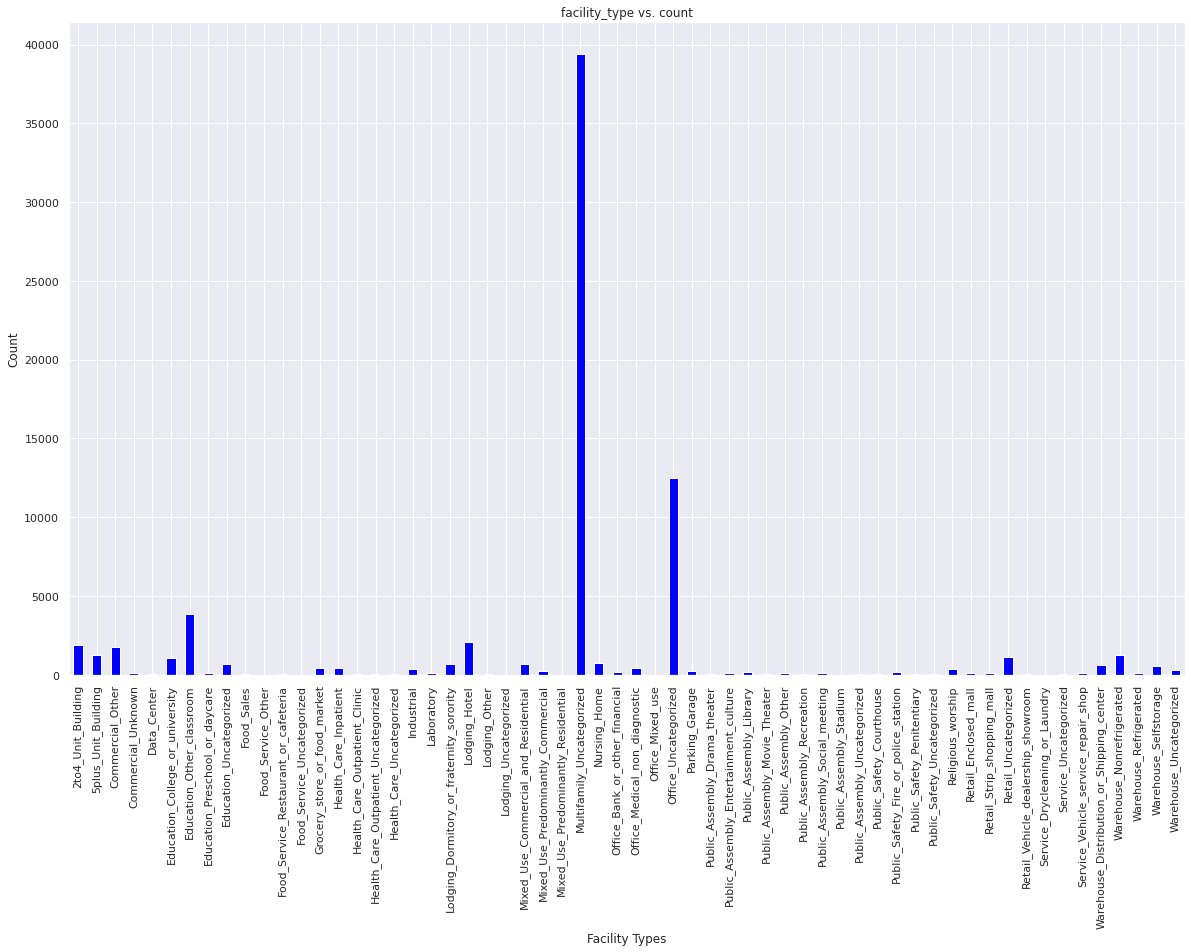

In [ ]:
ax = data.groupby('facility_type').size().plot(kind='bar',figsize=(20,12),color = 'blue')
ax.set_title('facility_type vs. count')
ax.set_xlabel('Facility Types')
ax.set_ylabel('Count')
ax.figure.savefig("Facility_types.pdf")

### 3.2 Categorical Data Visualization

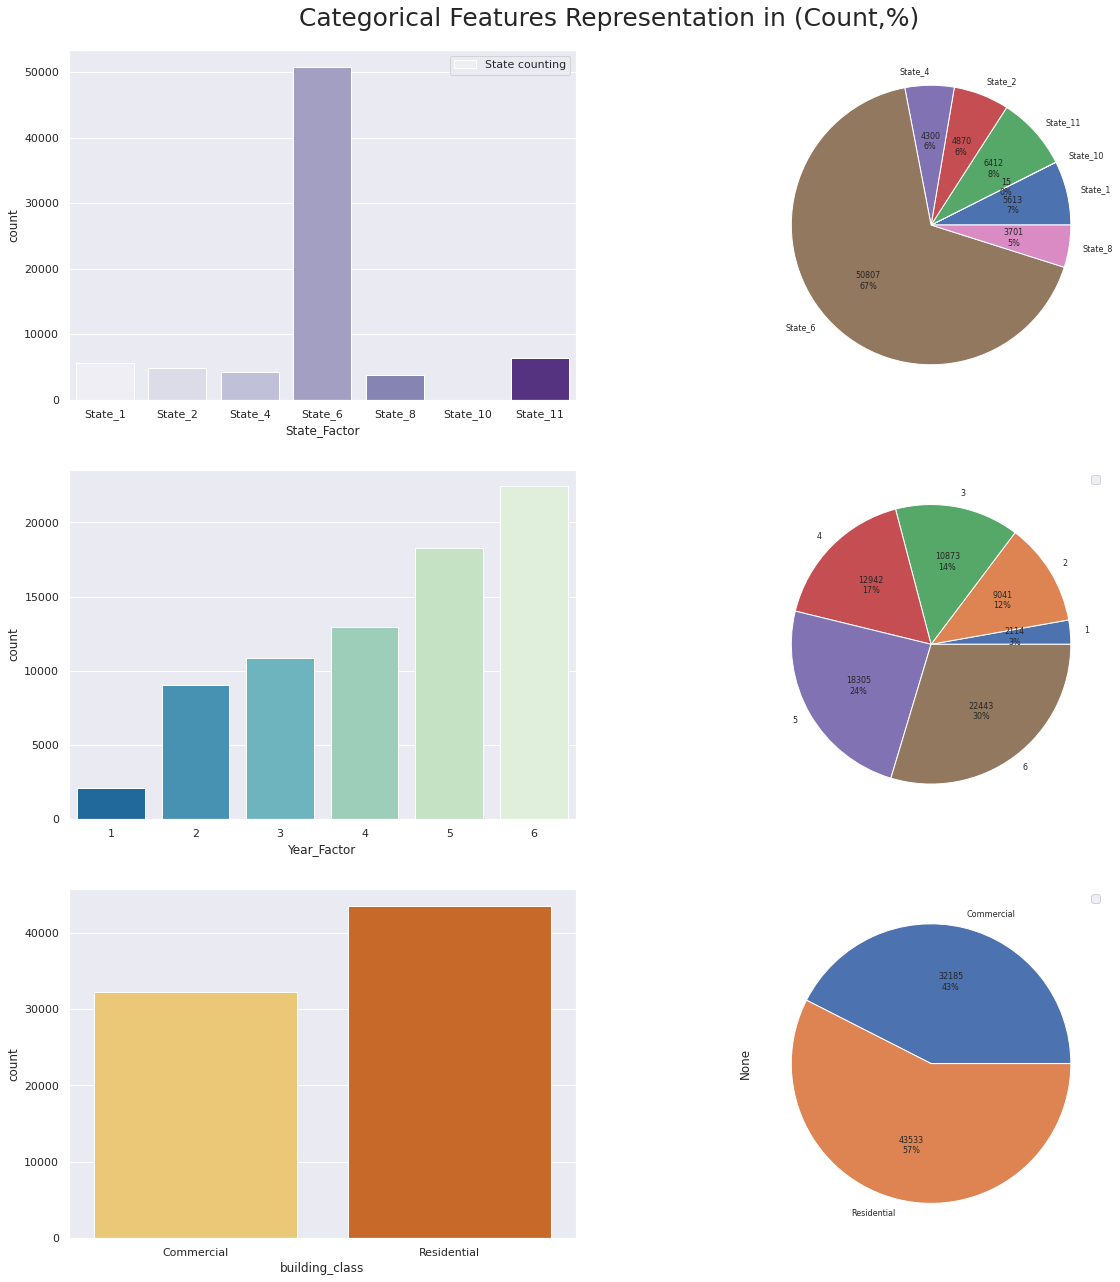

In [ ]:
def calc_per(val):
    return f'{val/100 *len(data):.0f}\n{val:.0f}%'

fig, ax = plt.subplots(3,2, figsize=(20,20), sharey=False)
fig.subplots_adjust(top=0.95)

sns.countplot(x=data['State_Factor'], label='State counting', ax = ax[0,0], palette='Purples') 
ax[0,0].legend();
data.groupby('State_Factor').size().plot(kind='pie', autopct=calc_per, 
                                           textprops={'fontsize':8}, ax= ax[0,1])
ax[0,1].set_ylabel('')

sns.countplot(x=data['Year_Factor'], label='Year_Factor', ax = ax[1,0], palette='GnBu_r')
ax[1,1].legend();
data.groupby('Year_Factor').size().plot(kind='pie', autopct=calc_per, 
                                           textprops={'fontsize':8}, ax= ax[1,1])
ax[1,1].set_ylabel('')

sns.countplot(x=data['building_class'], label='Building_class', ax = ax[2,0], palette='YlOrBr')
ax[2,1].legend();
data.groupby('building_class').size().plot(kind='pie', autopct=calc_per, 
                                           textprops={'fontsize':8}, ax= ax[2,1])

plt.suptitle('Categorical Features Representation in (Count,%)', fontsize = 25)
plt.savefig("Categorical Features Representation.pdf")

### 3.3 Year Factor against Site_eui

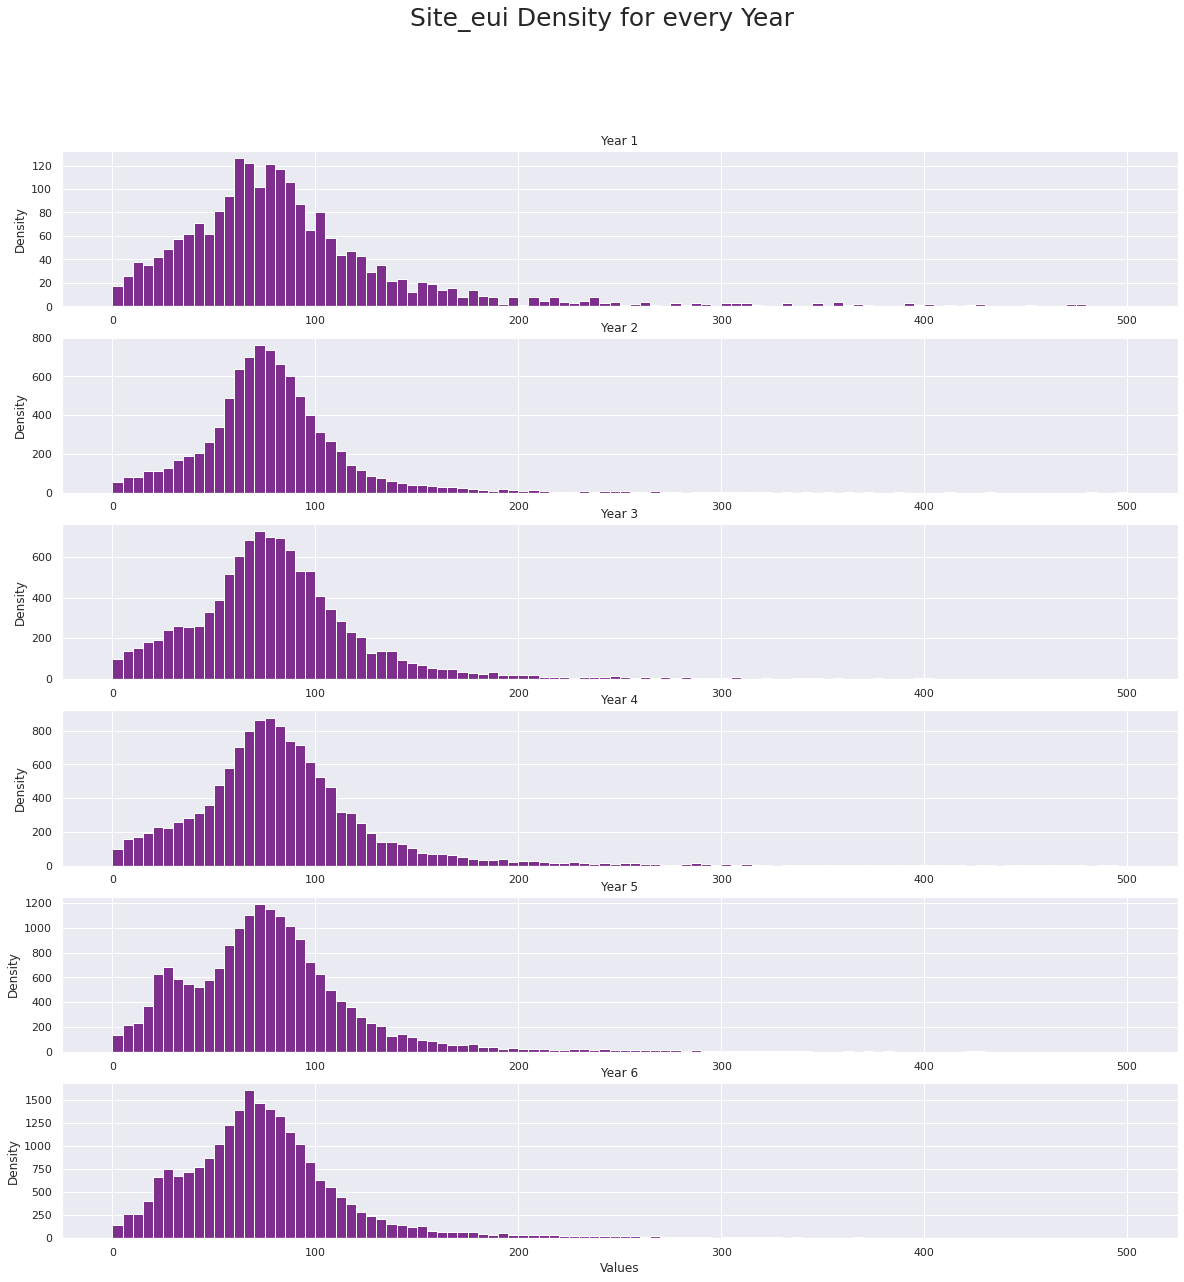

In [ ]:
plt.figure(figsize=(20,20))
for i in range(1, 7):
    plt.subplot(6, 1, i)
    plt.title(f'Year {i}')
    if i == 6:
        plt.xlabel('Values')
    plt.ylabel('Density')
    if i == 1:
        plt.suptitle('Site_eui Density for every Year', fontsize = 25)
    n, bins, patches = plt.hist(data.loc[data['Year_Factor'] == i,
                                             'site_eui'], 100,range=(0, 500), 
                                            density=False, facecolor='#7E2F8E')
    
plt.savefig("Year_Fector vs. Site_eui.pdf")

### 3.4 State Factor vs. Site Eui

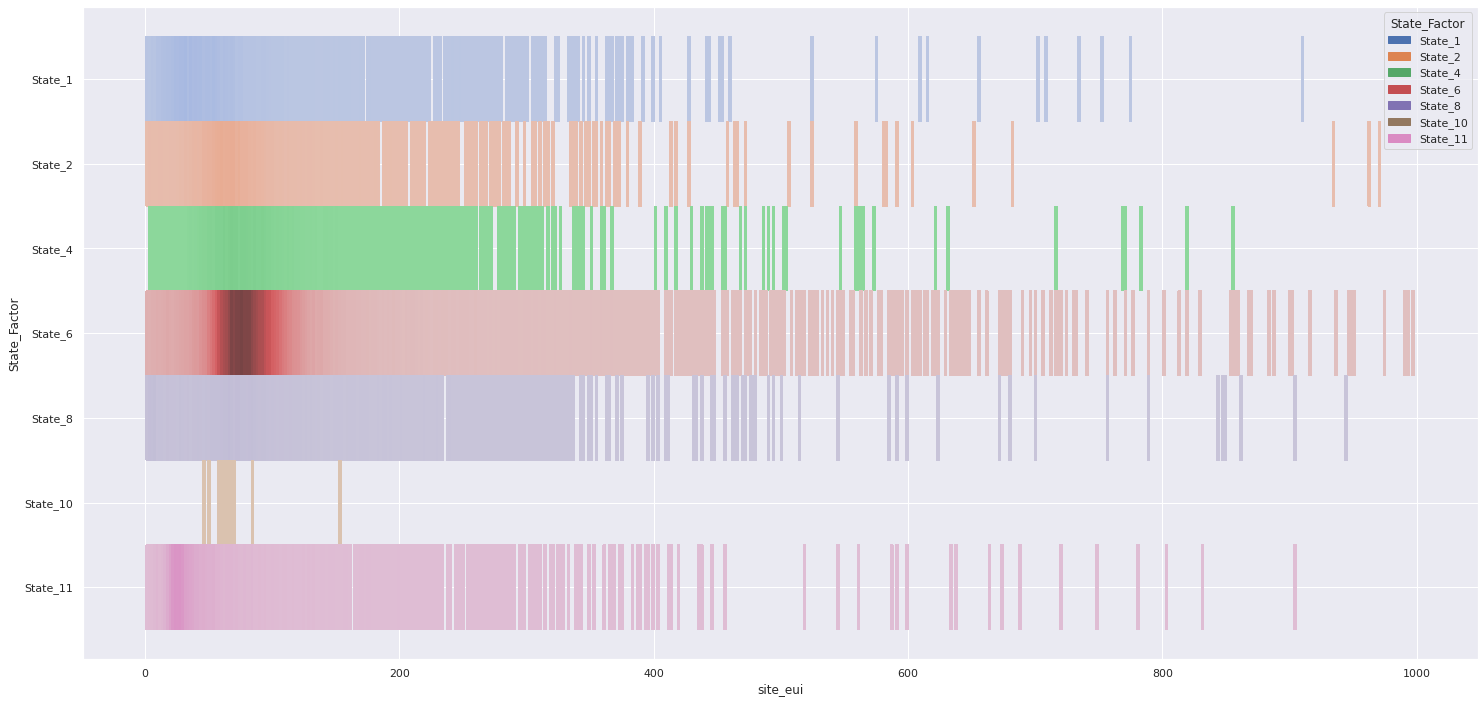

In [ ]:
sns.set(rc={'figure.figsize':(25,12)})
sns.histplot(data=data, y='State_Factor', x='site_eui', hue='State_Factor')
plt.savefig("State_Factors vs. Site_eui.pdf")

### 3.5 Scatter plot of Year and

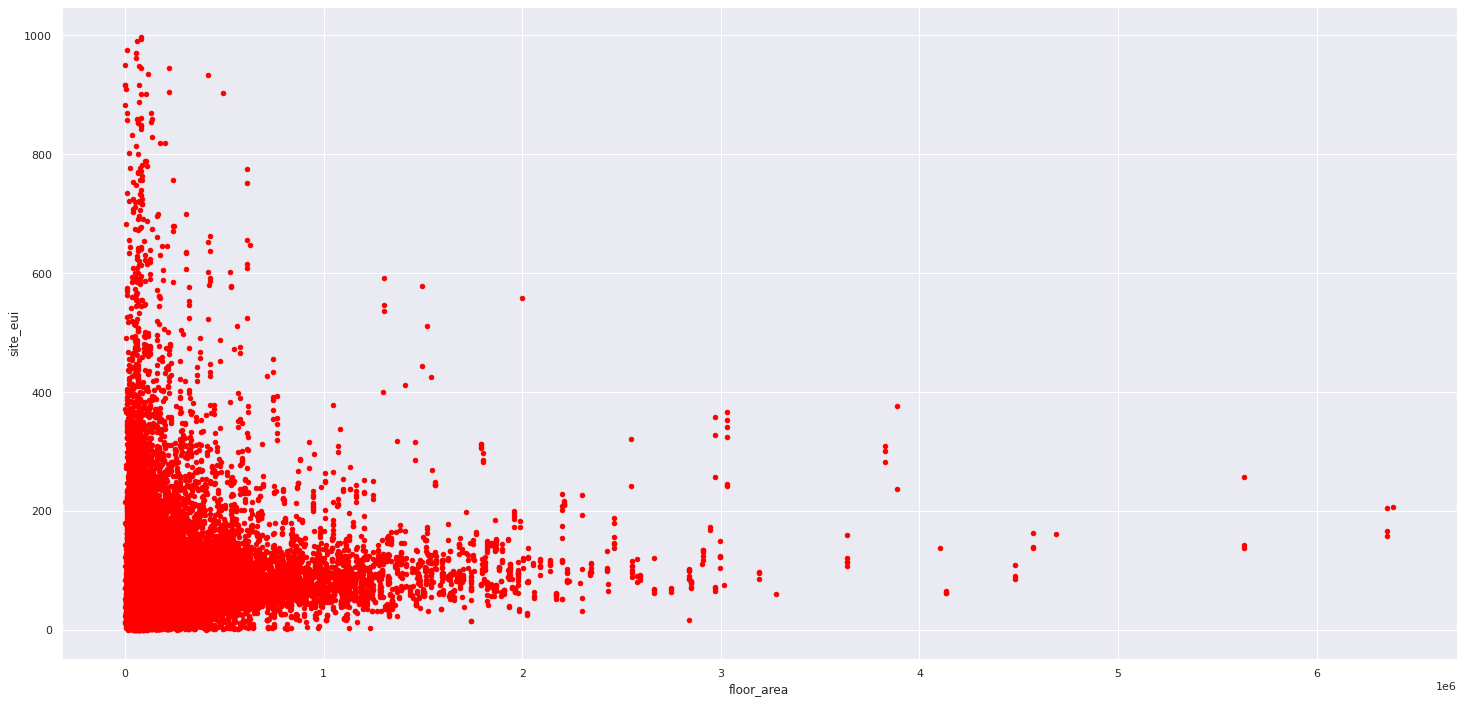

In [ ]:
data.plot(kind='scatter',x='floor_area',y='site_eui',color='red')
plt.savefig("Floor Area vs. Site_eui.pdf")

# Bonus work

I did choose the option 3 to generate the interective Graph Dashboard on the Google DataStudio. 

Here, I am attaching the link for my work on the DataStudio.

Link : https://datastudio.google.com/reporting/9a063900-4e02-4aca-bcd1-795fb0a31135



# Assignment 2 : Accelerate the Regression Data Mining Pipeline.

# Install Intel OneAPI.

In [ ]:
!pip install scikit-learn-intelex

# Preprocess as label encoder

In [ ]:
# Import label encoder 
from sklearn import preprocessing
# label_encoder object knows how to understand word labels. 
for col in ['State_Factor','building_class', 'facility_type']:
    label_encoder = preprocessing.LabelEncoder()
    # Encode labels in column 'Country'. 
    label_encoder.fit(data[col])
    data[col] = label_encoder.transform(data[col])
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui
0,2,0,0,8,9100.0,NaN,NaN,958.6,34,56.758065,...,0,246,182,119,16,NaN,NaN,NaN,NaN,31.436683
1,2,0,0,8,3200.0,NaN,NaN,958.6,34,56.758065,...,0,246,182,119,16,NaN,NaN,NaN,NaN,61.713289
2,2,0,0,8,10120.0,NaN,NaN,186.8,40,58.032258,...,0,102,28,2,0,NaN,NaN,NaN,NaN,98.581878
3,2,0,0,8,20854.0,NaN,NaN,92.0,22,46.629032,...,0,173,122,29,0,NaN,NaN,NaN,NaN,34.695615
4,2,0,0,8,93124.0,NaN,NaN,92.0,29,51.774194,...,0,176,117,30,0,NaN,NaN,NaN,NaN,43.336266


In [ ]:
X = data.drop('site_eui',axis=1)
Y = data['site_eui'] 

# Imput the Data

In [ ]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
# Imputation transformer for completing missing values.
imp_mean.fit(X)
features = imp_mean.transform(X)
features = pd.DataFrame(features)
features.head

<bound method NDFrame.head of         0    1    2     3         4           5          6      7     8   \
0      2.0  0.0  0.0   8.0    9100.0  1952.30844  61.049168  958.6  34.0   
1      2.0  0.0  0.0   8.0    3200.0  1952.30844  61.049168  958.6  34.0   
2      2.0  0.0  0.0   8.0   10120.0  1952.30844  61.049168  186.8  40.0   
3      2.0  0.0  0.0   8.0   20854.0  1952.30844  61.049168   92.0  22.0   
4      2.0  0.0  0.0   8.0   93124.0  1952.30844  61.049168   92.0  29.0   
...    ...  ...  ...   ...       ...         ...        ...    ...   ...   
75713  5.0  5.0  1.0  27.0  139416.0  1941.00000  71.000000   25.6   8.0   
75714  5.0  5.0  1.0  27.0  425135.0  1960.00000  49.000000   25.6   8.0   
75715  5.0  5.0  1.0  27.0  420189.0  1960.00000  53.000000   25.6   8.0   
75716  5.0  5.0  1.0  27.0  428316.0  1960.00000  55.000000   25.6   8.0   
75717  5.0  5.0  1.0  27.0  149653.0  1954.00000  64.000000   25.6   8.0   

              9   ...   52   53     54     55     56    5

# Convert data into StandarScaler

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# transform data
scaler.fit(features)
scaled = scaler.transform(features)

# Split the data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled, Y, test_size=0.25, random_state=46)

In [ ]:
from time import time
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Model 1: Liner Regression

In [ ]:
start_opt = time()
from sklearn.linear_model import LinearRegression

reg=LinearRegression()
reg.fit(X_train,y_train)
finish_opt = time()
y_pred=reg.predict(X_test)

f"Execution time with Intel(R) Extension for Scikit-learn: {(finish_opt - start_opt):.2f} s"

'Execution time with Intel(R) Extension for Scikit-learn: 0.02 s'

In [ ]:
from sklearn.metrics import mean_squared_error
import math

mse1_opt = (mean_squared_error(y_test,y_pred))
rmse1_opt = math.sqrt(mse1_opt)
r2_1_opt = round(reg.score(X_test, y_test),2)

print("The model performance for training set:")
print('RMSE is {}'.format(rmse1_opt))
print('R2 score is {}'.format(r2_1_opt))

The model performance for training set:
RMSE is 51.769366139181315
R2 score is 0.2


In [ ]:
from sklearnex import unpatch_sklearn
unpatch_sklearn()

In [ ]:
start_unopt = time()
from sklearn.linear_model import LinearRegression

reg=LinearRegression()
reg.fit(X_train,y_train)
finish_unopt = time()
y_pred=reg.predict(X_test)

f"Execution time with Intel(R) Extension for Scikit-learn: {(finish_opt - start_opt):.2f} s"

'Execution time with Intel(R) Extension for Scikit-learn: 0.02 s'

In [ ]:
mse1_unopt = (mean_squared_error(y_test,y_pred))
rmse1_unopt = math.sqrt(mse1_opt)
r2_1_unopt = round(reg.score(X_test, y_test),2)

print("The model performance for training set:")
print('RMSE is {}'.format(rmse1_unopt))
print('R2 score is {}'.format(r2_1_unopt))

The model performance for training set:
RMSE is 51.769366139181315
R2 score is 0.2


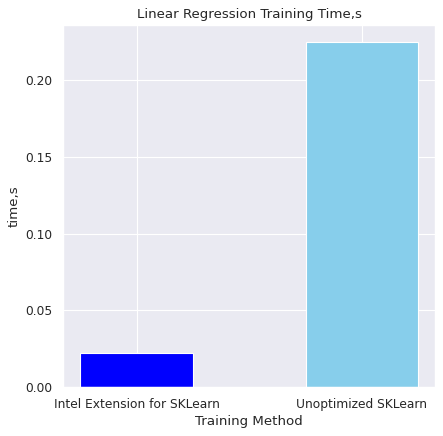

Performance Speedup:  10.090445328542094


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(6,6), dpi=80)
left = [1,2]
pred_times = [finish_opt - start_opt, finish_unopt - start_unopt]
tick_label = ['Intel Extension for SKLearn', 'Unoptimized SKLearn']
ax = plt.bar(left, pred_times, tick_label = tick_label, width = 0.5, color = ['blue', 'skyblue'])
plt.xlabel('Training Method'); plt.ylabel('time,s'); plt.title('Linear Regression Training Time,s')
plt.show()
print("Performance Speedup: ",(finish_unopt - start_unopt)/(finish_opt - start_opt))

In [ ]:
ax.figure.savefig("linearregression1.pdf")

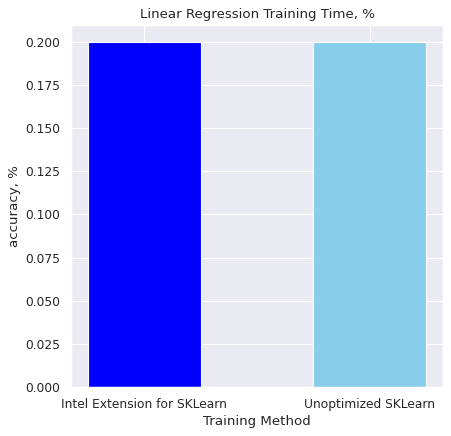

R2 Score Difference:  0.0


In [ ]:
figure(figsize=(6,6), dpi=80)
left = [1,2]
pred_acc = [r2_1_opt, r2_1_unopt]
tick_label = ['Intel Extension for SKLearn', 'Unoptimized SKLearn']
ax = plt.bar(left, pred_acc, tick_label = tick_label, width = 0.5, color = ['blue', 'skyblue'])
plt.xlabel('Training Method'); plt.ylabel('accuracy, %'); plt.title('Linear Regression Training Time, %')
plt.show()
print("R2 Score Difference: ",r2_1_opt - r2_1_unopt)

In [ ]:
ax.figure.savefig("linearregression1_r2.pdf")

# Model 2:  Lasso

In [ ]:
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
start_opt = time()
import sklearn.linear_model as lm 
reg_all = lm.LassoCV()
reg_all.fit(X_train, y_train)
finish_opt = time()

# model evaluation for training set
y_train_predict = reg_all.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict)))
r2 = round(reg_all.score(X_train, y_train),2)

print("The model performance for training set")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
f"Execution time with Intel(R) Extension for Scikit-learn: {(finish_opt - start_opt):.2f} s"

The model performance for training set
RMSE is 52.19700929779713
R2 score is 0.2


'Execution time with Intel(R) Extension for Scikit-learn: 3.92 s'

# Model 3:  Ridge

In [ ]:
start_opt = time()
import sklearn.linear_model as lm 
reg_all = lm.RidgeCV()
reg_all.fit(X_train, y_train)
finish_opt = time()

# model evaluation for training set
y_train_predict = reg_all.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict)))
r2 = round(reg_all.score(X_train, y_train),2)

print("The model performance for training set")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
f"Execution time with Intel(R) Extension for Scikit-learn: {(finish_opt - start_opt):.2f} s"

The model performance for training set
RMSE is 52.15136281850133
R2 score is 0.2


'Execution time with Intel(R) Extension for Scikit-learn: 0.48 s'

# Model 4: ElasticNet

In [ ]:
start_opt = time()
from sklearn.linear_model import ElasticNet
reg_all = ElasticNet(random_state=0)
reg_all.fit(X_train, y_train)
finish_opt = time()

# model evaluation for training set
y_train_predict = reg_all.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict)))
r2 = round(reg_all.score(X_train, y_train),2)


print("The model performance for training set")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
f"Execution time with Intel(R) Extension for Scikit-learn: {(finish_opt - start_opt):.2f} s"

The model performance for training set
RMSE is 53.141420363881146
R2 score is 0.17


'Execution time with Intel(R) Extension for Scikit-learn: 0.07 s'

# Model 5: RandomForestRegressor

In [ ]:
start_opt = time()
from sklearn.ensemble import RandomForestRegressor
reg_all = RandomForestRegressor(random_state=0)
reg_all.fit(X_train, y_train)
finish_opt = time()

# model evaluation for training set
y_train_predict = reg_all.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict)))
r2_2_opt = round(reg_all.score(X_train, y_train),2)

print("The model performance for training set")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
f"Execution time with Intel(R) Extension for Scikit-learn: {(finish_opt - start_opt):.2f} s"

The model performance for training set
RMSE is 24.229315874745833
R2 score is 0.17


'Execution time with Intel(R) Extension for Scikit-learn: 47.40 s'

In [ ]:
unpatch_sklearn()

In [ ]:
start_unopt = time()
from sklearn.ensemble import RandomForestRegressor
reg_all = RandomForestRegressor(random_state=0)
reg_all.fit(X_train, y_train)
finish_unopt = time()

# model evaluation for training set
y_train_predict = reg_all.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict)))
r2_2_unopt = round(reg_all.score(X_train, y_train),2)

print("The model performance for training set")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
f"Execution time with Intel(R) Extension for Scikit-learn: {(finish_unopt - start_unopt):.2f} s"

The model performance for training set
RMSE is 15.48680544337328
R2 score is 0.17


'Execution time with Intel(R) Extension for Scikit-learn: 100.97 s'

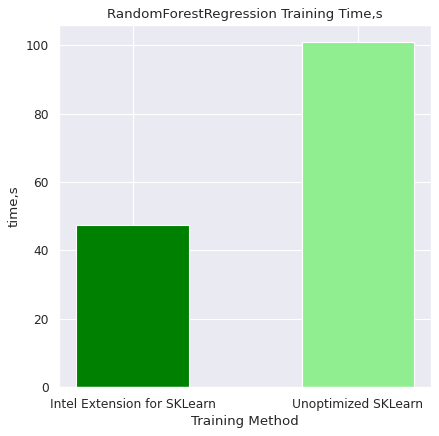

Performance Speedup:  2.1301607732601164


In [ ]:
figure(figsize=(6,6), dpi=80)
left = [1,2]
pred_times = [finish_opt - start_opt, finish_unopt - start_unopt]
tick_label = ['Intel Extension for SKLearn', 'Unoptimized SKLearn']
ax = plt.bar(left, pred_times, tick_label = tick_label, width = 0.5, color = ['green', 'lightgreen'])
plt.xlabel('Training Method'); plt.ylabel('time,s'); plt.title('RandomForestRegression Training Time,s')
plt.show()
print("Performance Speedup: ",(finish_unopt - start_unopt)/(finish_opt - start_opt))

In [ ]:
ax.figure.savefig("RandomeForest.pdf")8

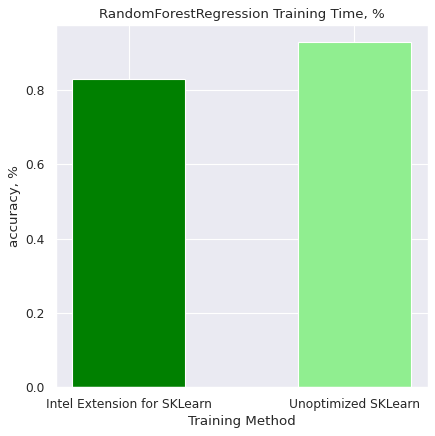

R2 Score Difference:  -0.10000000000000009


In [ ]:
figure(figsize=(6,6), dpi=80)
left = [1,2]
pred_acc = [r2_2_opt, r2_2_unopt]
tick_label = ['Intel Extension for SKLearn', 'Unoptimized SKLearn']
ax = plt.bar(left, pred_acc, tick_label = tick_label, width = 0.5, color = ['green', 'lightgreen'])
plt.xlabel('Training Method'); plt.ylabel('accuracy, %'); plt.title('RandomForestRegression Training Time, %')
plt.show()
print("R2 Score Difference: ",r2_2_opt - r2_2_unopt)

In [ ]:
ax.figure.savefig("RandomeForest_R2.pdf")

Conclusion : With doing simple preporcessing steps for the Dataset here, I get the best regression model as Random Forest. I was trying to implement all the model that is supported by the Intel OneAPI acceleration library for the Scikit Learn. 